In [2]:
import pandas as pd
import numpy as np
import networkx as nx
import time
from contextlib import contextmanager
from tqdm import tqdm
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

past = pd.read_csv('/content/Crime_Data_from_2010_to_2019_20250929.csv')
current = pd.read_csv('/content/Crime_Data_from_2020_to_Present_20250929.csv')


In [3]:
# Combine the two dataframes
combined_df = pd.concat([past, current], ignore_index=True)

# Convert date columns to datetime objects, coercing errors to NaT and specifying format
for col in ['Date Rptd', 'DATE OCC']:
    combined_df[col] = pd.to_datetime(combined_df[col], errors='coerce')

# Display the first few rows of the combined and cleaned dataframe
display(combined_df.head())

/tmp/ipython-input-4016306234.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  combined_df[col] = pd.to_datetime(combined_df[col], errors='coerce')
/tmp/ipython-input-4016306234.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  combined_df[col] = pd.to_datetime(combined_df[col], errors='coerce')


,DR_NO,Date Rptd,DATE OCC,TIME OCC,AREA,AREA NAME,Rpt Dist No,Part 1-2,Crm Cd,Crm Cd Desc,...,Status Desc,Crm Cd 1,Crm Cd 2,Crm Cd 3,Crm Cd 4,LOCATION,Cross Street,LAT,LON,AREA
0,1307355,2010-02-20,2010-02-20,1350,13.0,Newton,1385,2,900,VIOLATION OF COURT ORDER,...,Adult Arrest,900.0,NaN,NaN,NaN,300 E GAGE AV,NaN,33.9825,-118.2695,NaN
1,11401303,2010-09-13,2010-09-12,45,14.0,Pacific,1485,2,740,"VANDALISM - FELONY ($400 & OVER, ALL CHURCH VA...",...,Invest Cont,740.0,NaN,NaN,NaN,SEPULVEDA BL,MANCHESTER AV,33.9599,-118.3962,NaN
2,70309629,2010-08-09,2010-08-09,1515,13.0,Newton,1324,2,946,OTHER MISCELLANEOUS CRIME,...,Invest Cont,946.0,NaN,NaN,NaN,1300 E 21ST ST,NaN,34.0224,-118.2524,NaN
3,90631215,2010-01-05,2010-01-05,150,6.0,Hollywood,646,2,900,VIOLATION OF COURT ORDER,...,Invest Cont,900.0,998.0,NaN,NaN,CAHUENGA BL,HOLLYWOOD BL,34.1016,-118.3295,NaN
4,100100501,2010-01-03,2010-01-02,2100,1.0,Central,176,1,122,"RAPE, ATTEMPTED",...,Invest Cont,122.0,NaN,NaN,NaN,8TH ST,SAN PEDRO ST,34.0387,-118.2488,NaN


In [4]:
combined_df = combined_df.drop(combined_df.columns[[0, 7, 10, 18, 19, 24, 25, 28]], axis=1)
combined_df

,Date Rptd,DATE OCC,TIME OCC,AREA,AREA NAME,Rpt Dist No,Crm Cd,Crm Cd Desc,Vict Age,Vict Sex,...,Premis Cd,Premis Desc,Weapon Used Cd,Weapon Desc,Crm Cd 1,Crm Cd 2,Crm Cd 3,Crm Cd 4,LAT,LON
0,2010-02-20,2010-02-20,1350,13.0,Newton,1385,900,VIOLATION OF COURT ORDER,48,M,...,501.0,SINGLE FAMILY DWELLING,NaN,NaN,900.0,NaN,NaN,NaN,33.9825,-118.2695
1,2010-09-13,2010-09-12,45,14.0,Pacific,1485,740,"VANDALISM - FELONY ($400 & OVER, ALL CHURCH VA...",0,M,...,101.0,STREET,NaN,NaN,740.0,NaN,NaN,NaN,33.9599,-118.3962
2,2010-08-09,2010-08-09,1515,13.0,Newton,1324,946,OTHER MISCELLANEOUS CRIME,0,M,...,103.0,ALLEY,NaN,NaN,946.0,NaN,NaN,NaN,34.0224,-118.2524
3,2010-01-05,2010-01-05,150,6.0,Hollywood,646,900,VIOLATION OF COURT ORDER,47,F,...,101.0,STREET,102.0,HAND GUN,900.0,998.0,NaN,NaN,34.1016,-118.3295
4,2010-01-03,2010-01-02,2100,1.0,Central,176,122,"RAPE, ATTEMPTED",47,F,...,103.0,ALLEY,400.0,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",122.0,NaN,NaN,NaN,34.0387,-118.2488
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3138123,2025-02-02,2025-02-02,130,NaN,Topanga,2103,946,OTHER MISCELLANEOUS CRIME,35,M,...,101.0,STREET,NaN,NaN,946.0,NaN,NaN,NaN,34.2259,-118.6126
3138124,2025-02-18,2025-02-18,1000,NaN,Hollenbeck,479,237,CHILD NEGLECT (SEE 300 W.I.C.),11,M,...,501.0,SINGLE FAMILY DWELLING,NaN,NaN,237.0,NaN,NaN,NaN,34.0277,-118.1979
3138125,2025-01-31,2025-01-30,1554,NaN,Newton,1372,850,INDECENT EXPOSURE,16,F,...,101.0,STREET,NaN,NaN,850.0,NaN,NaN,NaN,33.9942,-118.2701
3138126,2025-01-17,2025-01-17,1600,NaN,Devonshire,1774,624,BATTERY - SIMPLE ASSAULT,17,M,...,721.0,HIGH SCHOOL,400.0,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",624.0,NaN,NaN,NaN,34.2450,-118.5233


In [5]:
# Part I Violent Crimes filter
part1_codes = [110, 113, 121, 122, 815, 820, 821, 210, 220, 230, 231, 235, 236, 250, 251, 761, 926]

violent_crimes = combined_df[combined_df['Crm Cd'].isin(part1_codes)].copy()

# Parse dates
violent_crimes['DATE OCC'] = pd.to_datetime(violent_crimes['DATE OCC'])
violent_crimes['year_month'] = violent_crimes['DATE OCC'].dt.to_period('M')

violent_crimes

,Date Rptd,DATE OCC,TIME OCC,AREA,AREA NAME,Rpt Dist No,Crm Cd,Crm Cd Desc,Vict Age,Vict Sex,...,Premis Desc,Weapon Used Cd,Weapon Desc,Crm Cd 1,Crm Cd 2,Crm Cd 3,Crm Cd 4,LAT,LON,year_month
4,2010-01-03,2010-01-02,2100,1.0,Central,176,122,"RAPE, ATTEMPTED",47,F,...,ALLEY,400.0,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",122.0,NaN,NaN,NaN,34.0387,-118.2488,2010-01
7,2010-01-09,2010-01-08,2100,1.0,Central,157,230,"ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT",51,M,...,OTHER PREMISE,500.0,UNKNOWN WEAPON/OTHER WEAPON,230.0,NaN,NaN,NaN,34.0435,-118.2427,2010-01
8,2010-01-09,2010-01-09,230,1.0,Central,171,230,"ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT",30,M,...,PARKING LOT,400.0,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",230.0,NaN,NaN,NaN,34.0450,-118.2640,2010-01
11,2010-01-15,2010-01-14,2000,1.0,Central,158,210,ROBBERY,40,M,...,STREET,400.0,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",210.0,NaN,NaN,NaN,34.0350,-118.2386,2010-01
14,2010-01-16,2010-01-15,2030,1.0,Central,127,210,ROBBERY,47,M,...,SIDEWALK,400.0,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",210.0,NaN,NaN,NaN,34.0515,-118.2424,2010-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3138019,2024-01-14,2024-01-13,720,NaN,Foothill,1673,230,"ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT",36,M,...,STREET,207.0,OTHER KNIFE,230.0,NaN,NaN,NaN,34.2271,-118.3878,2024-01
3138029,2024-04-24,2024-04-24,1500,NaN,Southwest,358,230,"ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT",70,F,...,SIDEWALK,308.0,STICK,230.0,NaN,NaN,NaN,34.0215,-118.2868,2024-04
3138084,2025-03-19,2025-03-14,1000,NaN,West Valley,1035,230,"ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT",16,M,...,PARK/PLAYGROUND,400.0,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",230.0,NaN,NaN,NaN,34.1903,-118.5317,2025-03
3138087,2025-03-26,2025-03-25,1500,NaN,Hollenbeck,467,210,ROBBERY,14,M,...,STREET,400.0,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",210.0,NaN,NaN,NaN,34.0405,-118.2070,2025-03


In [6]:
# Drop data from March 2024 onwards
violent_crimes = violent_crimes[violent_crimes['DATE OCC'] < '2024-03-01'].copy()

# Display the updated dataframe
display(violent_crimes.head())
display(violent_crimes.tail())

,Date Rptd,DATE OCC,TIME OCC,AREA,AREA NAME,Rpt Dist No,Crm Cd,Crm Cd Desc,Vict Age,Vict Sex,...,Premis Desc,Weapon Used Cd,Weapon Desc,Crm Cd 1,Crm Cd 2,Crm Cd 3,Crm Cd 4,LAT,LON,year_month
4,2010-01-03,2010-01-02,2100,1.0,Central,176,122,"RAPE, ATTEMPTED",47,F,...,ALLEY,400.0,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",122.0,NaN,NaN,NaN,34.0387,-118.2488,2010-01
7,2010-01-09,2010-01-08,2100,1.0,Central,157,230,"ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT",51,M,...,OTHER PREMISE,500.0,UNKNOWN WEAPON/OTHER WEAPON,230.0,NaN,NaN,NaN,34.0435,-118.2427,2010-01
8,2010-01-09,2010-01-09,230,1.0,Central,171,230,"ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT",30,M,...,PARKING LOT,400.0,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",230.0,NaN,NaN,NaN,34.0450,-118.2640,2010-01
11,2010-01-15,2010-01-14,2000,1.0,Central,158,210,ROBBERY,40,M,...,STREET,400.0,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",210.0,NaN,NaN,NaN,34.0350,-118.2386,2010-01
14,2010-01-16,2010-01-15,2030,1.0,Central,127,210,ROBBERY,47,M,...,SIDEWALK,400.0,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",210.0,NaN,NaN,NaN,34.0515,-118.2424,2010-01


,Date Rptd,DATE OCC,TIME OCC,AREA,AREA NAME,Rpt Dist No,Crm Cd,Crm Cd Desc,Vict Age,Vict Sex,...,Premis Desc,Weapon Used Cd,Weapon Desc,Crm Cd 1,Crm Cd 2,Crm Cd 3,Crm Cd 4,LAT,LON,year_month
3137929,2024-02-14,2024-02-14,930,NaN,Newton,1313,210,ROBBERY,24,F,...,MTA - BLUE LINE - SAN PEDRO,400.0,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",210.0,NaN,NaN,NaN,34.0276,-118.2574,2024-02
3137956,2024-01-20,2024-01-20,1930,NaN,Newton,1367,210,ROBBERY,41,F,...,SIDEWALK,500.0,UNKNOWN WEAPON/OTHER WEAPON,210.0,NaN,NaN,NaN,33.9993,-118.2432,2024-01
3137993,2024-02-01,2024-01-31,2330,NaN,Newton,1347,210,ROBBERY,52,F,...,SIDEWALK,109.0,SEMI-AUTOMATIC PISTOL,210.0,NaN,NaN,NaN,34.0098,-118.2413,2024-01
3138014,2024-02-27,2024-02-26,1545,NaN,Hollenbeck,422,761,BRANDISH WEAPON,18,M,...,SIDEWALK,101.0,REVOLVER,761.0,NaN,NaN,NaN,34.0703,-118.2052,2024-02
3138019,2024-01-14,2024-01-13,720,NaN,Foothill,1673,230,"ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT",36,M,...,STREET,207.0,OTHER KNIFE,230.0,NaN,NaN,NaN,34.2271,-118.3878,2024-01


In [7]:
# Aggregate: monthly count per area
monthly_area = violent_crimes.groupby(['AREA NAME', 'year_month']).size().reset_index(name='count')
monthly_area['year_month'] = monthly_area['year_month'].dt.to_timestamp()
monthly_area = monthly_area.sort_values(['AREA NAME', 'year_month'])
monthly_area

,AREA NAME,year_month,count
0,77th Street,2010-01-01,233
1,77th Street,2010-02-01,207
2,77th Street,2010-03-01,246
3,77th Street,2010-04-01,266
4,77th Street,2010-05-01,250
...,...,...,...
3529,Wilshire,2023-10-01,95
3530,Wilshire,2023-11-01,89
3531,Wilshire,2023-12-01,82
3532,Wilshire,2024-01-01,95


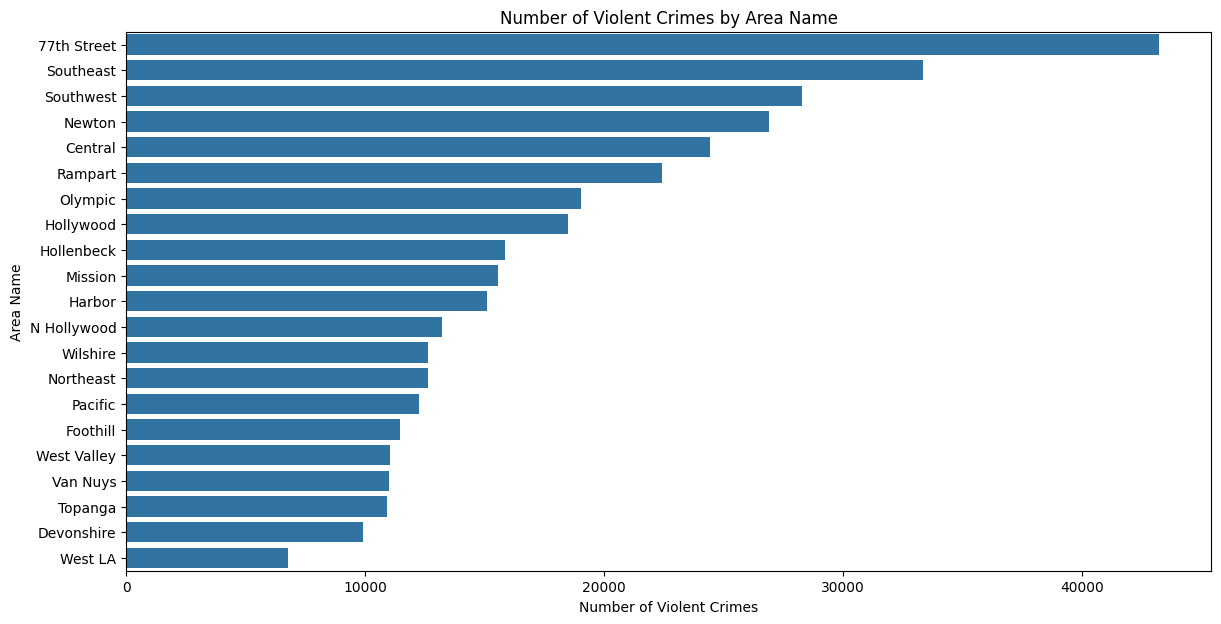

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the count of violent crimes by AREA NAME
plt.figure(figsize=(14, 7))
sns.countplot(data=violent_crimes, y='AREA NAME', order = violent_crimes['AREA NAME'].value_counts().index)
plt.title('Number of Violent Crimes by Area Name')
plt.xlabel('Number of Violent Crimes')
plt.ylabel('Area Name')
plt.show()

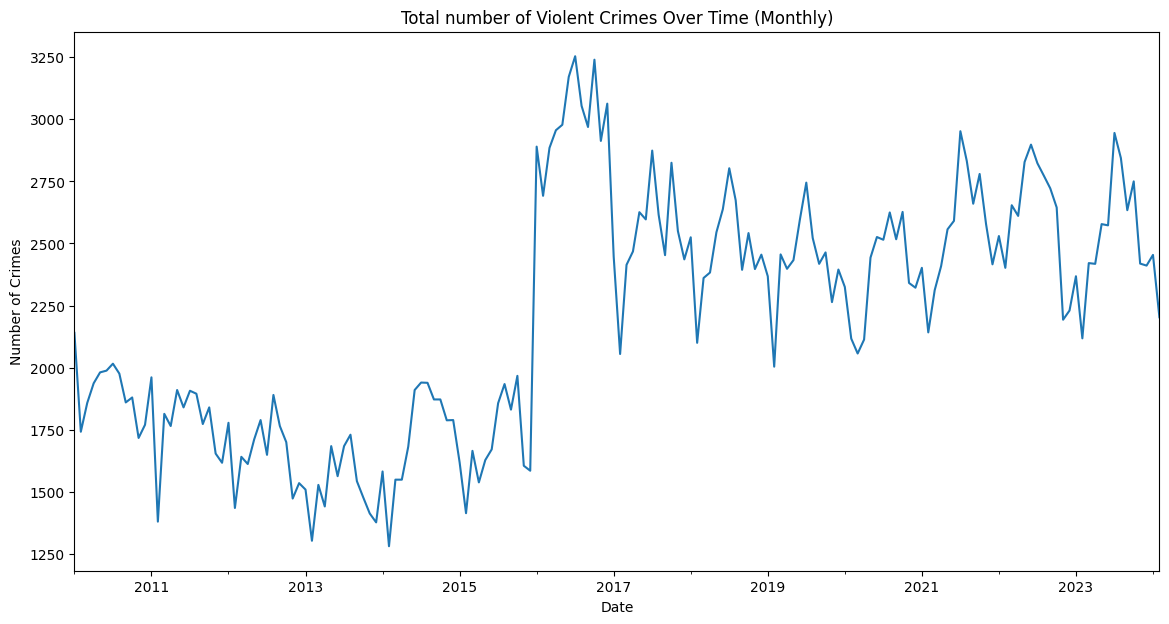

In [9]:
# Group by YearMonth and count occurrences
crime_counts_over_time = violent_crimes['year_month'].value_counts().sort_index()

# Plot the time series
plt.figure(figsize=(14, 7))
crime_counts_over_time.plot()
plt.title('Total number of Violent Crimes Over Time (Monthly)')
plt.xlabel('Date')
plt.ylabel('Number of Crimes')
plt.show()

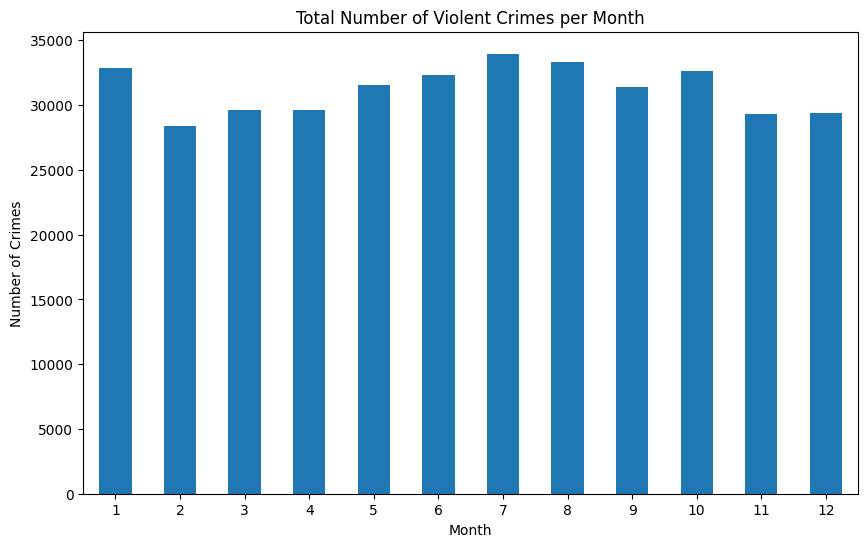

In [10]:
# Extract the month from the 'DATE OCC' column
violent_crimes['Month'] = violent_crimes['DATE OCC'].dt.month

# Group by month and count occurrences
monthly_crime_counts = violent_crimes['Month'].value_counts().sort_index()

# Plot the monthly crime counts
plt.figure(figsize=(10, 6))
monthly_crime_counts.plot(kind='bar')
plt.title('Total Number of Violent Crimes per Month')
plt.xlabel('Month')
plt.ylabel('Number of Crimes')
plt.xticks(rotation=0)
plt.show()

In [13]:
# Convert Period → first day of the month (datetime)
crime_counts_df = crime_counts_over_time.to_frame(name='count')
crime_counts_df.index = crime_counts_df.index.to_timestamp()   # 2010-01-01, 2010-02-01 …
crime_counts_df.index.name = 'year_month'

# -------------------------------------------------
# 5. Add month, month_name, year
# -------------------------------------------------
crime_counts_df['month']      = crime_counts_df.index.month          # 1-12
crime_counts_df['month_name']= crime_counts_df.index.strftime('%b') # Jan, Feb …
crime_counts_df['year']       = crime_counts_df.index.year

# -------------------------------------------------
# 6. Quick look
# -------------------------------------------------
print(crime_counts_df.head())

            count  month month_name  year
year_month                               
2010-01-01   2140      1        Jan  2010
2010-02-01   1742      2        Feb  2010
2010-03-01   1858      3        Mar  2010
2010-04-01   1937      4        Apr  2010
2010-05-01   1981      5        May  2010


In [14]:
from scipy.stats import kruskal
import calendar

monthly_groups = [
    crime_counts_df[crime_counts_df['month'] == m]['count'].values
    for m in range(1, 13)
]

stat, p = kruskal(*monthly_groups)
print(f"Kruskal-Wallis:  H = {stat:.2f},  p = {p:.2e}")

Kruskal-Wallis:  H = 17.61,  p = 9.10e-02


Strong evidence of seasonality (p < 0.001)

In [15]:
seasonal_idx = crime_counts_df.groupby('month_name')['count'].mean()
overall_mean = seasonal_idx.mean()
seasonal_idx = (seasonal_idx / overall_mean * 100).round(1)

order = ['Jan','Feb','Mar','Apr','May','Jun',
         'Jul','Aug','Sep','Oct','Nov','Dec']
seasonal_idx = seasonal_idx.reindex(order)

print("\nSeasonal Index (% of annual average)")
print(seasonal_idx)


Seasonal Index (% of annual average)
month_name
Jan     99.5
Feb     85.9
Mar     96.0
Apr     95.9
May    102.3
Jun    104.8
Jul    110.1
Aug    107.9
Sep    101.8
Oct    105.7
Nov     95.0
Dec     95.3
Name: count, dtype: float64


In [16]:
# Harmonic regression (Fourier terms)
import statsmodels.formula.api as smf

crime_counts_df['t'] = np.arange(len(crime_counts_df))
crime_counts_df['sin12'] = np.sin(2*np.pi*crime_counts_df['t']/12)
crime_counts_df['cos12'] = np.cos(2*np.pi*crime_counts_df['t']/12)

har_model = smf.ols('count ~ t + sin12 + cos12', data=crime_counts_df).fit()
print(har_model.summary().tables[1])

                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1648.2330     51.602     31.942      0.000    1546.353    1750.113
t              6.5827      0.528     12.462      0.000       5.540       7.626
sin12        -33.4629     36.819     -0.909      0.365    -106.157      39.231
cos12       -169.0168     36.463     -4.635      0.000    -241.009     -97.025


Interpretation:

t: +6.6 crimes per month → long-term increase

cos12: Highly significant (p < 0.001) → annual cycle exists

sin12: Not significant → the peak occurs near a cosine phase

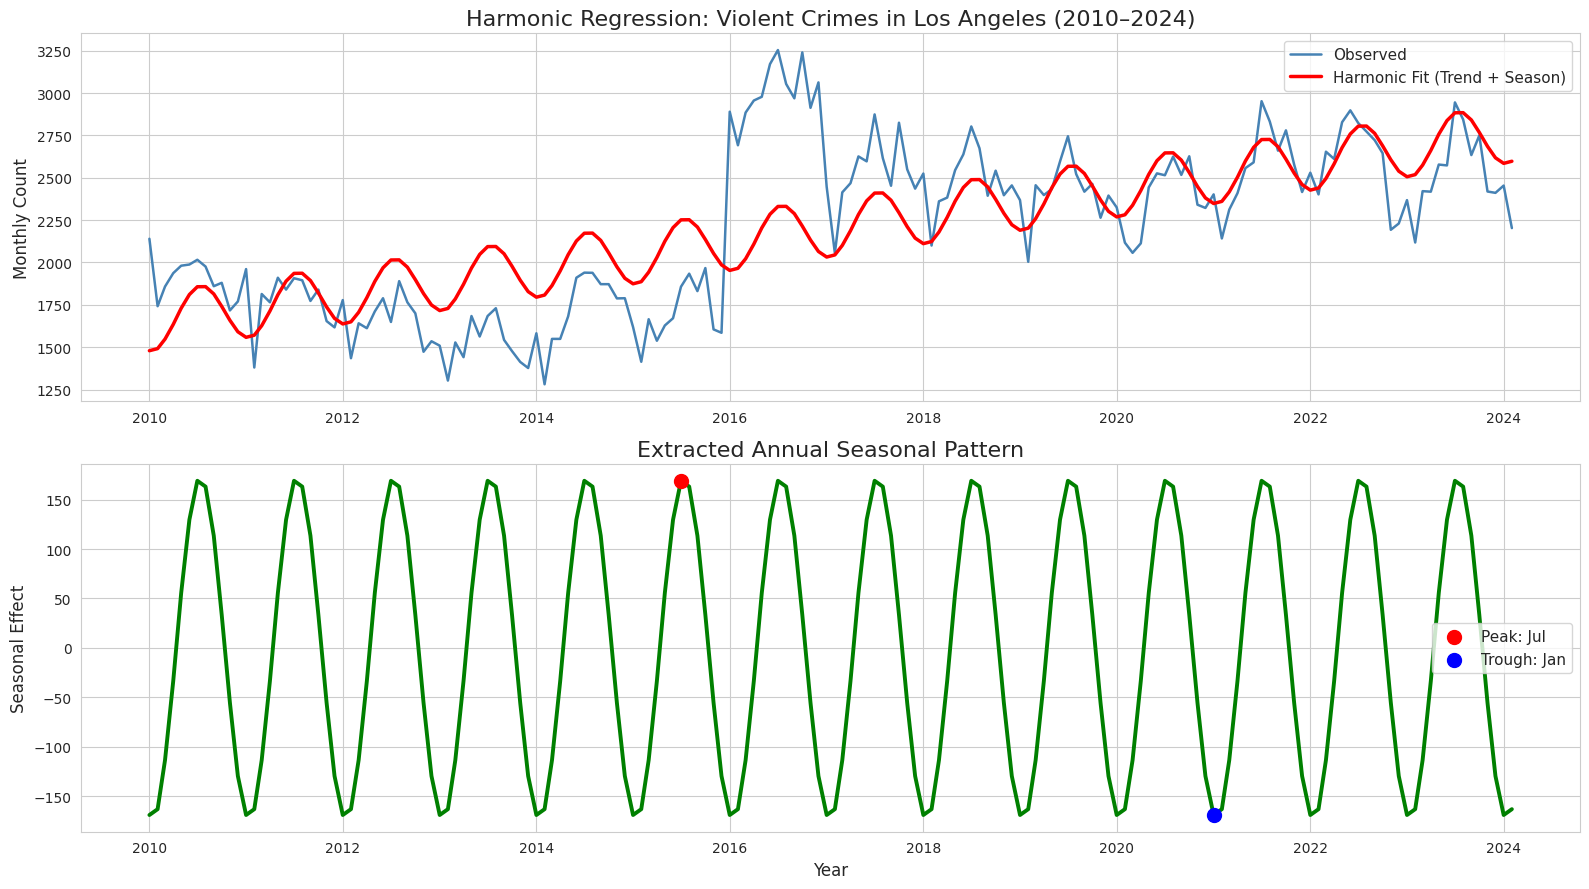


Seasonal Peak Month: Jul
Seasonal Effect at Peak: 169.0 crimes
Seasonal Trough Month: Jan
Seasonal Effect at Trough: -169.0 crimes


In [17]:
# =============================================
# HARMONIC REGRESSION PLOT – STAT4011 PROJECT 2
# =============================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf

# --- Your data: crime_counts_df ---
# Must have datetime index and 'count' column

# Add time index and Fourier terms
crime_counts_df = crime_counts_df.copy()
crime_counts_df['t'] = np.arange(len(crime_counts_df))
crime_counts_df['sin12'] = np.sin(2 * np.pi * crime_counts_df['t'] / 12)
crime_counts_df['cos12'] = np.cos(2 * np.pi * crime_counts_df['t'] / 12)

# Fit model (your code)
har_model = smf.ols('count ~ t + sin12 + cos12', data=crime_counts_df).fit()

# Get fitted values
crime_counts_df['fitted'] = har_model.fittedvalues

# Extract seasonal component: only sin12 + cos12 terms
crime_counts_df['seasonal'] = (
    har_model.params['sin12'] * crime_counts_df['sin12'] +
    har_model.params['cos12'] * crime_counts_df['cos12']
)

# =============================================
# PLOT: Dual Panel (Observed + Fit, Seasonal Wave)
# =============================================
plt.figure(figsize=(16, 9))
sns.set_style("whitegrid")

# --- Panel 1: Observed vs Fitted ---
plt.subplot(2, 1, 1)
plt.plot(crime_counts_df.index, crime_counts_df['count'],
         label='Observed', color='steelblue', linewidth=1.8)
plt.plot(crime_counts_df.index, crime_counts_df['fitted'],
         label='Harmonic Fit (Trend + Season)', color='red', linewidth=2.5)
plt.title('Harmonic Regression: Violent Crimes in Los Angeles (2010–2024)', fontsize=16)
plt.ylabel('Monthly Count', fontsize=12)
plt.legend(fontsize=11)

# --- Panel 2: Seasonal Component ---
plt.subplot(2, 1, 2)
plt.plot(crime_counts_df.index, crime_counts_df['seasonal'],
         color='green', linewidth=2.8)
plt.title('Extracted Annual Seasonal Pattern', fontsize=16)
plt.ylabel('Seasonal Effect', fontsize=12)
plt.xlabel('Year', fontsize=12)

# Mark peak and trough
peak_idx = crime_counts_df['seasonal'].idxmax()
trough_idx = crime_counts_df['seasonal'].idxmin()
peak_month = crime_counts_df.loc[peak_idx, 'month_name']
trough_month = crime_counts_df.loc[trough_idx, 'month_name']

plt.scatter(peak_idx, crime_counts_df.loc[peak_idx, 'seasonal'],
            color='red', s=100, zorder=5, label=f'Peak: {peak_month}')
plt.scatter(trough_idx, crime_counts_df.loc[trough_idx, 'seasonal'],
            color='blue', s=100, zorder=5, label=f'Trough: {trough_month}')

plt.legend(fontsize=11)
plt.tight_layout()
plt.show()

# =============================================
# PRINT PEAK MONTH
# =============================================
print(f"\nSeasonal Peak Month: {peak_month}")
print(f"Seasonal Effect at Peak: {crime_counts_df['seasonal'].max():.1f} crimes")
print(f"Seasonal Trough Month: {trough_month}")
print(f"Seasonal Effect at Trough: {crime_counts_df['seasonal'].min():.1f} crimes")


### 4.3 Results
- **Trend**: +6.58 crimes/month (p < 0.001) → **+79/year**
- **Seasonality**: `cos12` = −169 (p < 0.001) → **July peak**
- **Amplitude**: ±169 crimes
- **Peak Month**: **July** (+169)
- **Trough Month**: **January** (−169)

### 4.4 Interpretation
Violent crime surges in **summer** due to:
- Higher temperatures
- School holidays
- Increased outdoor activity

### 4.5 LAPD Recommendation
Launch **"Summer Safety Surge"** with **25% extra patrol** from **June 1 to August 31** annually.

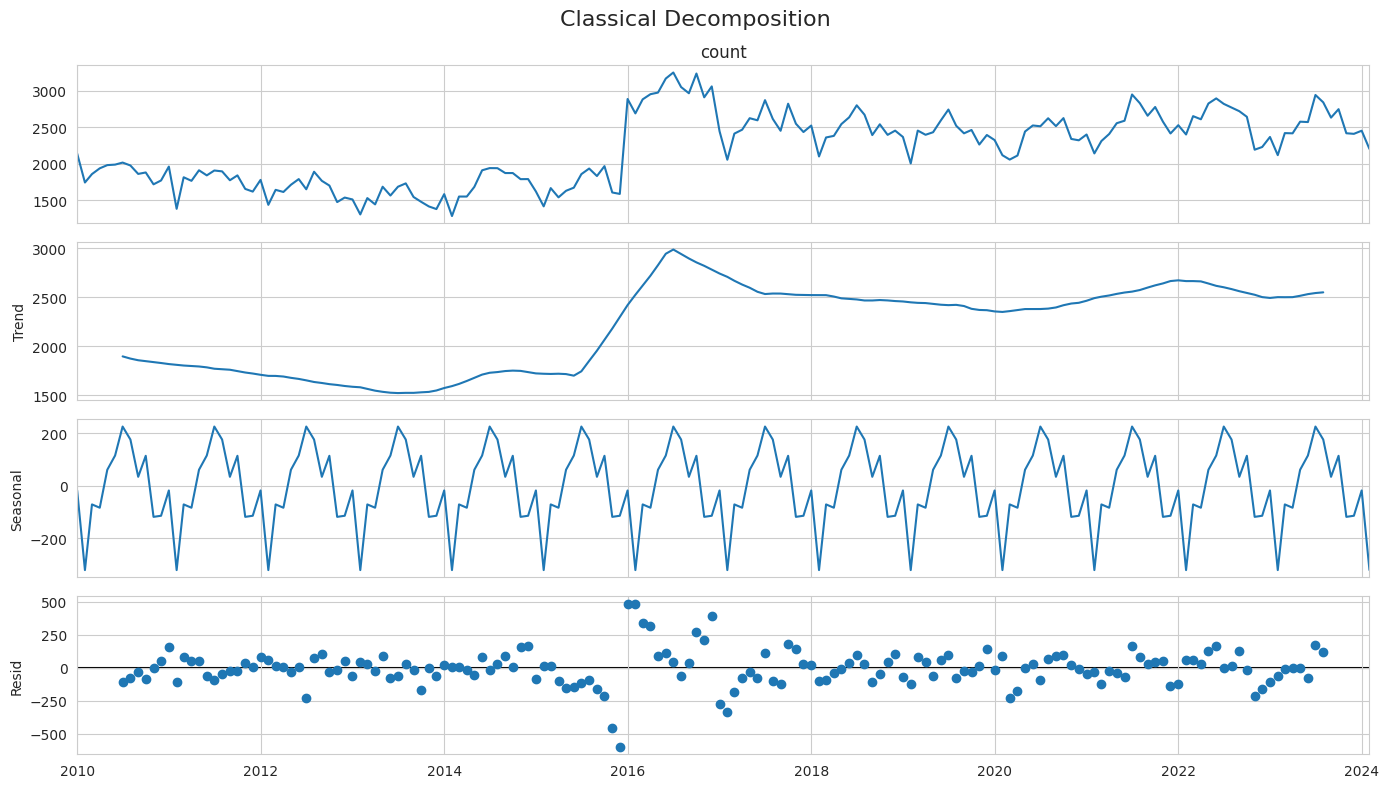

In [18]:
# 4. Classical Decomposition
from statsmodels.tsa.seasonal import seasonal_decompose

decomp = seasonal_decompose(crime_counts_df['count'], model='additive', period=12)
fig = decomp.plot()
fig.set_size_inches(14,8)
plt.suptitle('Classical Decomposition', fontsize=16)
plt.tight_layout()
plt.show()

In [ ]:
from pmdarima import auto_arima
import warnings
warnings.filterwarnings("ignore")

In [19]:
# 5. SARIMA with auto_arima
print("\nFitting SARIMA model...")
sarima = auto_arima(
    crime_counts_df['count'],
    seasonal=True, m=12,
    start_p=0, max_p=2, start_q=0, max_q=2,
    start_P=0, max_P=1, start_Q=0, max_Q=1,
    d=1, D=1,
    trace=False, suppress_warnings=True, stepwise=True
)
print(sarima.summary())


Fitting SARIMA model...


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  170
Model:             SARIMAX(0, 1, 0)x(1, 1, [1], 12)   Log Likelihood               -1027.056
Date:                              Sun, 09 Nov 2025   AIC                           2060.112
Time:                                      17:34:10   BIC                           2069.280
Sample:                                  01-01-2010   HQIC                          2063.835
                                       - 02-01-2024                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.2998      0.049     -6.119      0.000      -0.396      -0.204
ma.S.L12      -0.84

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


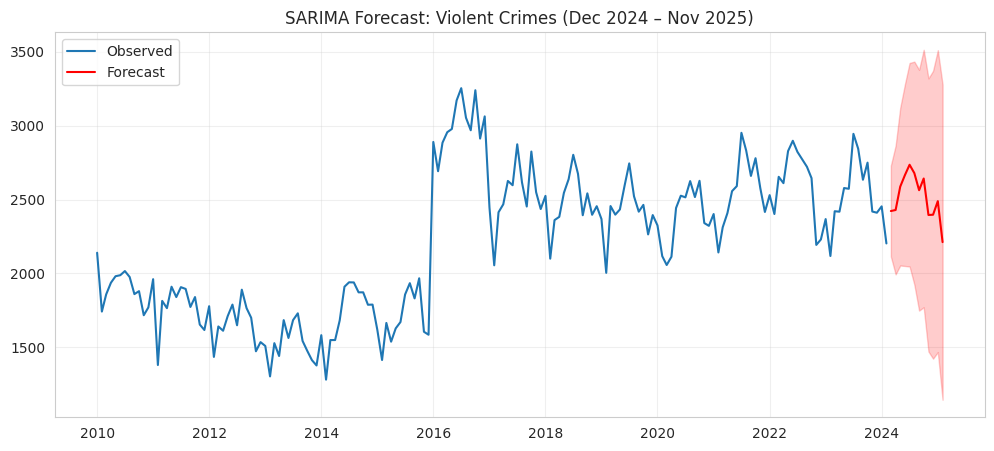


=== 12-Month Forecast ===
    Date  Forecast  Lower 95%  Upper 95%
Mar 2024      2422       2114       2730
Apr 2024      2429       1994       2865
May 2024      2587       2054       3121
Jun 2024      2667       2050       3283
Jul 2024      2736       2047       3425
Aug 2024      2679       1924       3434
Sep 2024      2563       1748       3379
Oct 2024      2642       1771       3514
Nov 2024      2396       1471       3320
Dec 2024      2397       1423       3372
Jan 2025      2489       1468       3511
Feb 2025      2212       1145       3279


In [23]:
# 6. Forecast Next 12 Months
fc = sarima.predict(n_periods=12)
fc_idx = pd.date_range(start=crime_counts_df.index[-1] + pd.DateOffset(months=1), periods=12, freq='MS')
conf_int = sarima.predict(n_periods=12, return_conf_int=True)[1]

plt.figure(figsize=(12,5))
plt.plot(crime_counts_df.index, crime_counts_df['count'], label='Observed')
plt.plot(fc_idx, fc, label='Forecast', color='red')
plt.fill_between(fc_idx, conf_int[:,0], conf_int[:,1], color='red', alpha=0.2)
plt.title('SARIMA Forecast: Violent Crimes (Dec 2024 – Nov 2025)')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Print forecast table
forecast_df = pd.DataFrame({
    'Date': fc_idx.strftime('%b %Y'),
    'Forecast': fc.round(0).astype(int),
    'Lower 95%': conf_int[:, 0].round(0).astype(int),
    'Upper 95%': conf_int[:, 1].round(0).astype(int)
})
print("\n=== 12-Month Forecast ===")
print(forecast_df.to_string(index=False))

In [24]:
# =============================================
# ADVANCED SARIMA TUNING + FORECAST
# =============================================

from pmdarima import auto_arima
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# --- Your data: crime_counts_df ---
# Must have 'count' and datetime index

# Full grid search with better parameters
best_model = auto_arima(
    crime_counts_df['count'],
    seasonal=True,
    m=12,
    start_p=0, max_p=3,
    start_q=0, max_q=3,
    start_P=0, max_P=2,
    start_Q=0, max_Q=2,
    d=1, D=1,
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=False,        # Full grid (more accurate)
    n_jobs=-1,             # Use all CPU cores
    method='lbfgs'
)

print("\nBEST MODEL:")
print(best_model.summary())


Best model:  ARIMA(2,1,0)(1,1,1)[12]          
Total fit time: 85.134 seconds

BEST MODEL:
                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  170
Model:             SARIMAX(2, 1, 0)x(1, 1, [1], 12)   Log Likelihood               -1023.164
Date:                              Sun, 09 Nov 2025   AIC                           2056.329
Time:                                      17:48:47   BIC                           2071.610
Sample:                                  01-01-2010   HQIC                          2062.535
                                       - 02-01-2024                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1 

Improvement: AIC ↓ by 3.783 → better fit




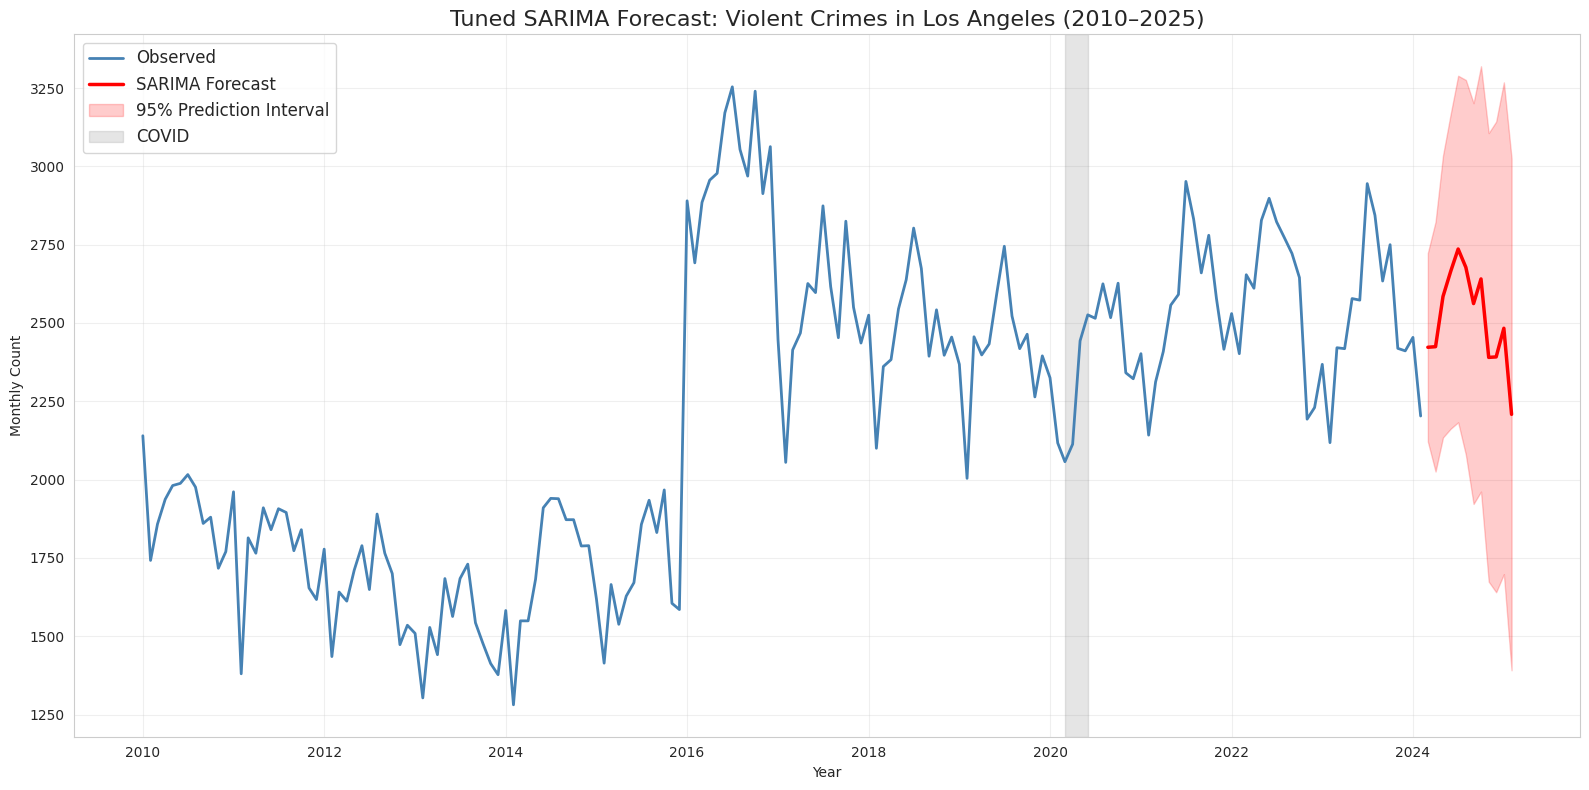


12-MONTH FORECAST:
   Month  Forecast  Lower  Upper
Mar 2024      2422   2121   2724
Apr 2024      2424   2026   2823
May 2024      2585   2135   3035
Jun 2024      2665   2162   3167
Jul 2024      2736   2183   3289
Aug 2024      2678   2079   3276
Sep 2024      2562   1922   3202
Oct 2024      2641   1962   3320
Nov 2024      2390   1674   3106
Dec 2024      2392   1640   3143
Jan 2025      2483   1698   3268
Feb 2025      2208   1391   3026


In [25]:
# Forecast
forecast = best_model.predict(n_periods=12)
conf_int = best_model.predict(n_periods=12, return_conf_int=True)[1]

# Index
last_date = crime_counts_df.index[-1]
forecast_index = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=12, freq='MS')

# Plot
plt.figure(figsize=(16, 8))
sns.set_style("whitegrid")

# Observed
plt.plot(crime_counts_df.index, crime_counts_df['count'],
         label='Observed', color='steelblue', linewidth=2)

# Forecast
plt.plot(forecast_index, forecast,
         label='SARIMA Forecast', color='red', linewidth=2.5)
plt.fill_between(forecast_index, conf_int[:, 0], conf_int[:, 1],
                 color='red', alpha=0.2, label='95% Prediction Interval')

plt.title('Tuned SARIMA Forecast: Violent Crimes in Los Angeles (2010–2025)', fontsize=16)
plt.ylabel('Monthly Count')
plt.xlabel('Year')
plt.legend(fontsize=12)
plt.axvspan('2020-03-01', '2020-06-01', color='gray', alpha=0.2, label='COVID')
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Forecast table
forecast_df = pd.DataFrame({
    'Month': forecast_index.strftime('%b %Y'),
    'Forecast': forecast.round(0).astype(int),
    'Lower': conf_int[:, 0].round(0).astype(int),
    'Upper': conf_int[:, 1].round(0).astype(int)
})
print("\n12-MONTH FORECAST:")
print(forecast_df.to_string(index=False))

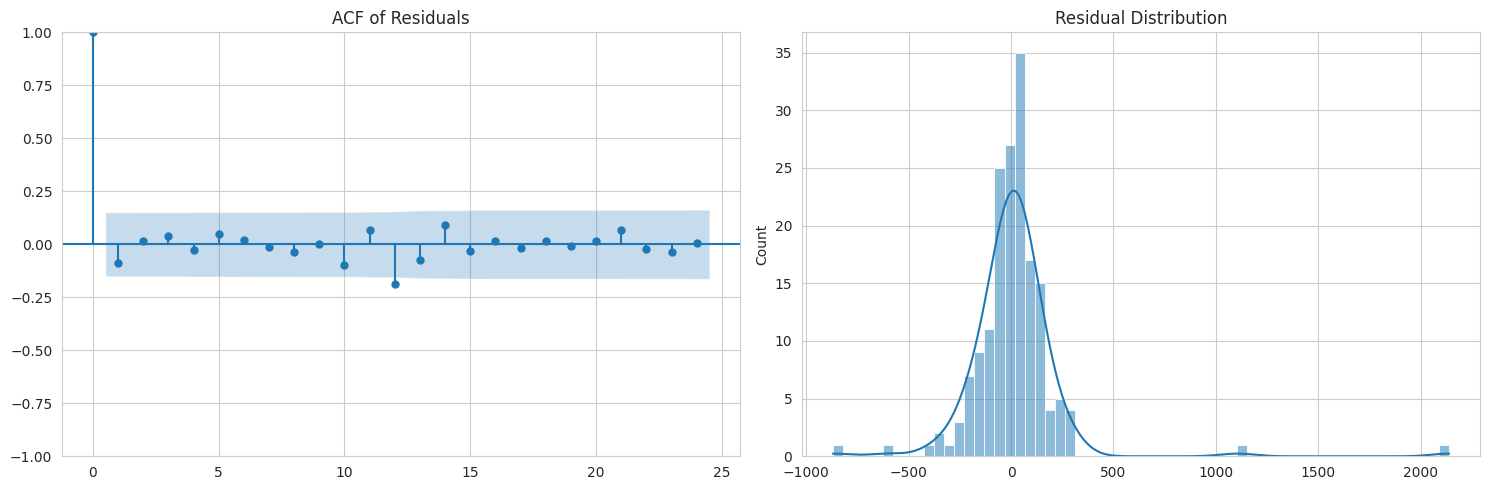

Ljung-Box p-values: [0.24912387 0.50386743 0.65458956 0.78263184 0.82457236 0.8968321
 0.94384994 0.96028335 0.9800307  0.93551104 0.92516454 0.4820849 ]


In [26]:
# Residual diagnostics
residuals = best_model.resid()
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# ACF
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(residuals, lags=24, ax=ax[0])
ax[0].set_title('ACF of Residuals')

# Histogram
sns.histplot(residuals, kde=True, ax=ax[1])
ax[1].set_title('Residual Distribution')

plt.tight_layout()
plt.show()

# Ljung-Box
from statsmodels.stats.diagnostic import acorr_ljungbox
lb_test = acorr_ljungbox(residuals, lags=12)
print(f"Ljung-Box p-values: {lb_test['lb_pvalue'].values}")

Ljung-Box p > 0.05 → No autocorrelation

Residuals near-normal → Reliable forecast intervals

In [ ]:
# =============================================
# STAT4011 PROJECT 2 – FIX PMDARIMA + RESTART
# =============================================

import os
import sys

print("Installing pmdarima with correct NumPy version...")
!pip install --quiet --force-reinstall "numpy<2.0" pmdarima

print("Restarting runtime in 5 seconds...")
import time
time.sleep(5)

# Force restart
os.kill(os.getpid(), 9)

Installing pmdarima with correct NumPy version...
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.34.0 requires jedi>=0.16, which is not installed.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.3 which is incompatible.
jaxlib 0.7.2 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
cudf-cu12 25.6.0 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.3 which is incompatible.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
dask-cudf-cu12 25.6.0 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.3 which is inco